In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/MLstability/training_data/'
dset = 'random/'
featurefolder = 'ressummaryfeaturesxgbv6Norbits10000.0Nout1000/'
features = ['C_AMDnear', 'C_AMDfar', 'C_AMDouter']

In [3]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

In [4]:
trainX.shape

(20000, 3)

In [5]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [6]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.83998092                                          
ERROR                                               
0.022322015231901846                                
HOLDOUT SCORE                                       
0.8496168506941727                                  
SCORE:                                                                       
0.8388069400000001                                                           
ERROR                                                                        
0.02132286628250878                                                          
HOLDOUT SCORE                                                                
0.8507927813474409                                                           
SCORE:                                                                        
0.8294596200000001                                                            
ERROR                                                   

0.006645592815441718                                                           
HOLDOUT SCORE                                                                  
0.890448772201388                                                              
SCORE:                                                                         
0.8269361                                                                      
ERROR                                                                          
0.023021512760774458                                                           
HOLDOUT SCORE                                                                  
0.8371143352112813                                                             
SCORE:                                                                         
0.87406386                                                                     
ERROR                                                                          
0.0065161129161600394                   

In [7]:
best

{'x_learning_rate': 0.1687683480481511,
 'x_max_depth': 4,
 'x_min_child': 1.0,
 'x_pos_weight': 1.848176033923668,
 'x_subsample': 0.8188333385766203,
 'x_tree_colsample': 0.9381900446503051}

In [8]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.874424+0.00156245	test-auc:0.870493+0.00628557
[1]	train-auc:0.876693+0.00402587	test-auc:0.871141+0.00639984
[2]	train-auc:0.875609+0.0079003	test-auc:0.869287+0.0106464
[3]	train-auc:0.879974+0.00351895	test-auc:0.874371+0.00554523
[4]	train-auc:0.879683+0.00517245	test-auc:0.873172+0.00731483
[5]	train-auc:0.880523+0.00326773	test-auc:0.874218+0.00635297
[6]	train-auc:0.882178+0.00233574	test-auc:0.875992+0.00557758
[7]	train-auc:0.883227+0.0019072	test-auc:0.877067+0.00518284
[8]	train-auc:0.884115+0.00146973	test-auc:0.877797+0.0053453
[9]	train-auc:0.884886+0.00155916	test-auc:0.878604+0.0051182
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.874424       0.001562       0.870493      0.006286
1        0.876693       0.004026       0.871141      0.006400
2        0.875609       0.007900       0.869287      0.010646
3        0.879974       0.003519       0.874371      0.005545
4        0.879683       0.005172       0.873172      0.007315
5  

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.9381900446503051, gamma=0,
              learning_rate=0.1687683480481511, max_delta_step=0, max_depth=4,
              min_child_weight=1.0, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.848176033923668,
              seed=None, silent=True, subsample=0.8188333385766203)

In [10]:
dill.dump([model, features, featurefolder], open(datapath+"../models/AMD_random.pkl", "wb"))

Text(0.5, 1.0, 'ROC curve (AUC = 0.901)')

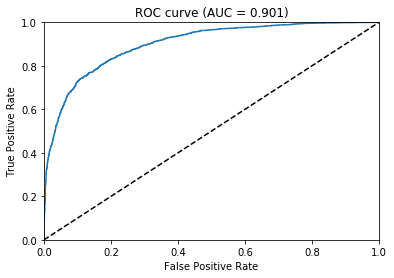

In [11]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features, filter=False)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [12]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features, filter=False)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.0008068087045103312, recall = 1.0, precision = 0.3938
Threshold 0.002042278880253434, recall = 0.9994921279837481, precision = 0.39709443099273606
Threshold 0.0026730389799922705, recall = 0.9994921279837481, precision = 0.39862264533117275
Threshold 0.003631517058238387, recall = 0.9994921279837481, precision = 0.3998374644453474
Threshold 0.004477680195122957, recall = 0.9994921279837481, precision = 0.40105971061748524
Threshold 0.0054695080034434795, recall = 0.9994921279837481, precision = 0.40245398773006136
Threshold 0.0060615455731749535, recall = 0.9994921279837481, precision = 0.4037751333606894
Threshold 0.006666429806500673, recall = 0.9994921279837481, precision = 0.40510498147385754
Threshold 0.0078071970492601395, recall = 0.9994921279837481, precision = 0.40644361833952913
Threshold 0.008773335255682468, recall = 0.9994921279837481, precision = 0.40779113137173645
Threshold 0.010193964466452599, recall = 0.9994921279837481, precision = 0.40923268870867124
Th

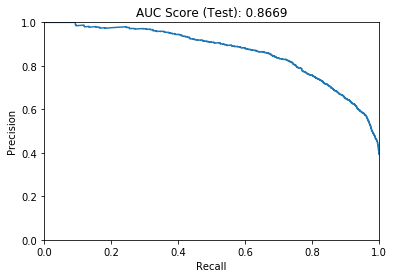

In [13]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 225.50000000000003)

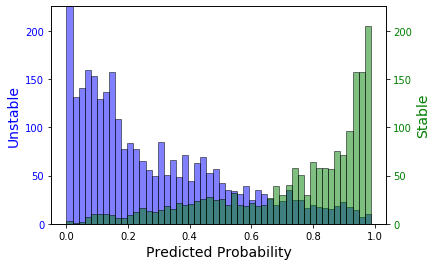

In [14]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features, filter=False)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

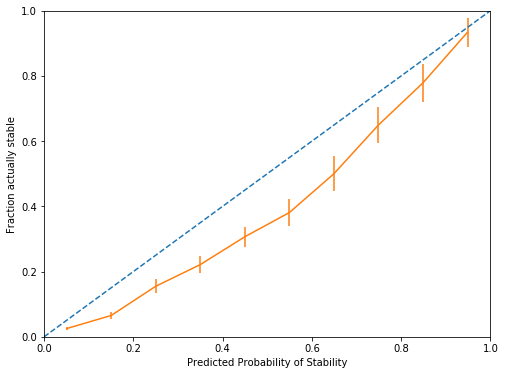

In [15]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10, filter=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

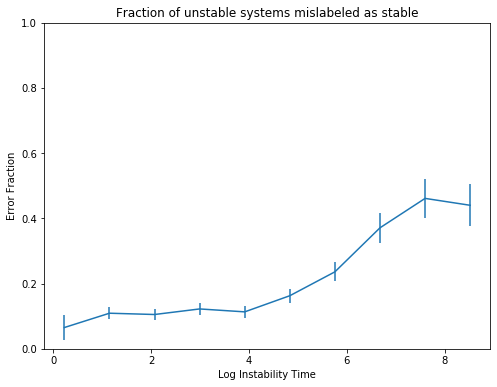

In [16]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10, filter=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

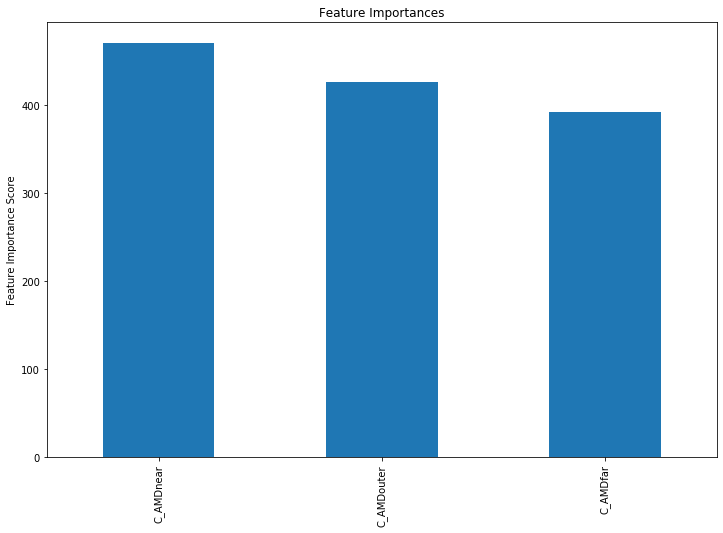

In [17]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

# slice data between ranges of instability times

# slice data between ranges of instability times

# things that are just unstable might be very similar to things that are just stable

# predict at half a billion, then repredict at half a billion whether you'll be unstable at a billion

# do the summary features change with time?

# try training on just unstable systems